In [1]:
import pandas as pd
import os

# -----------------------------
# 1. Data Loading
# -----------------------------
DATA_PATH = "../data/raw/Fraud_Data.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"File not found at {DATA_PATH}")

df = pd.read_csv(DATA_PATH)

print(f"Data loaded successfully")
print(f"Shape: {df.shape}")


Data loaded successfully
Shape: (151112, 11)


In [2]:
print("\nColumn names:")
print(df.columns.tolist())

print("\nData types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nDuplicate rows:")
print(df.duplicated().sum())



Column names:
['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class']

Data types:
user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

Missing values per column:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Duplicate rows:
0


In [3]:
# Convert timestamps
df["signup_time"] = pd.to_datetime(df["signup_time"], errors="coerce")
df["purchase_time"] = pd.to_datetime(df["purchase_time"], errors="coerce")

print("\nNull timestamps after parsing:")
print(df[["signup_time", "purchase_time"]].isnull().sum())
# Time sanity: purchase should not happen before signup
invalid_time_order = df[df["purchase_time"] < df["signup_time"]]

print(f"\nTransactions where purchase_time < signup_time: {len(invalid_time_order)}")

if len(invalid_time_order) > 0:
    display(invalid_time_order.head())




Null timestamps after parsing:
signup_time      0
purchase_time    0
dtype: int64

Transactions where purchase_time < signup_time: 0


In [4]:
df["time_since_signup_seconds"] = (
    df["purchase_time"] - df["signup_time"]
).dt.total_seconds()

print("\nTime since signup summary (seconds):")
print(df["time_since_signup_seconds"].describe())

print("\nNegative or zero time_since_signup values:")
print((df["time_since_signup_seconds"] <= 0).sum())



Time since signup summary (seconds):
count    1.511120e+05
mean     4.932029e+06
std      3.126263e+06
min      1.000000e+00
25%      2.186754e+06
50%      4.926346e+06
75%      7.644524e+06
max      1.036797e+07
Name: time_since_signup_seconds, dtype: float64

Negative or zero time_since_signup values:
0


In [5]:
# ============================================================
# GEOLOCATION INTEGRATION: IP -> COUNTRY (TASK 1 REQUIREMENT)
# ============================================================

import pandas as pd

# -------------------------------
# 1. Load IP-to-Country Mapping
# -------------------------------
ip_country_path = "../data/raw/IpAddress_to_Country.csv"
ip_df = pd.read_csv(ip_country_path)

# -------------------------------
# 2. Convert IPs to Integer Format
# -------------------------------
# Create a clean integer IP column without touching raw data
df["ip_address_int"] = df["ip_address"].astype(int)

ip_df["lower_bound_ip_address"] = ip_df["lower_bound_ip_address"].astype(int)
ip_df["upper_bound_ip_address"] = ip_df["upper_bound_ip_address"].astype(int)

# -------------------------------
# 3. Sort for Range-Based Merge
# -------------------------------
df = df.sort_values("ip_address_int")
ip_df = ip_df.sort_values("lower_bound_ip_address")

# -------------------------------
# 4. Range-Based Lookup (merge_asof)
# -------------------------------
df = pd.merge_asof(
    df,
    ip_df,
    left_on="ip_address_int",
    right_on="lower_bound_ip_address",
    direction="backward"
)

# Validate that IP is within the upper bound
invalid_mask = df["ip_address_int"] > df["upper_bound_ip_address"]
df.loc[invalid_mask, "country"] = "Unknown"

# Clean up helper columns
df.drop(
    columns=["lower_bound_ip_address", "upper_bound_ip_address"],
    inplace=True
)

df["country"] = df["country"].fillna("Unknown")

# -------------------------------
# 5. Sanity Check
# -------------------------------
print("Top 10 countries by transaction count:")
display(df["country"].value_counts().head(10))

print("\nPercentage of Unknown countries:")
print((df["country"] == "Unknown").mean() * 100)


Top 10 countries by transaction count:


country
United States        58049
Unknown              21966
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Name: count, dtype: int64


Percentage of Unknown countries:
14.53623802212928


In [6]:
# ============================================================
# FRAUD ANALYSIS BY COUNTRY
# ============================================================

country_stats = (
    df.groupby("country")
    .agg(
        total_txns=("class", "count"),
        fraud_txns=("class", "sum")
    )
)

country_stats["fraud_rate"] = (
    country_stats["fraud_txns"] / country_stats["total_txns"]
)

# Filter for statistical significance
country_stats = country_stats[country_stats["total_txns"] >= 100]

# Sort by fraud rate
country_stats_sorted = country_stats.sort_values(
    "fraud_rate", ascending=False
)

display(country_stats_sorted.head(10))


,total_txns,fraud_txns,fraud_rate
country,,,
Ecuador,106,28,0.264151
Tunisia,118,31,0.262712
Peru,119,31,0.260504
Ireland,240,55,0.229167
New Zealand,278,62,0.223022
Saudi Arabia,264,50,0.189394
Denmark,490,78,0.159184
Chile,417,64,0.153477
Greece,231,33,0.142857


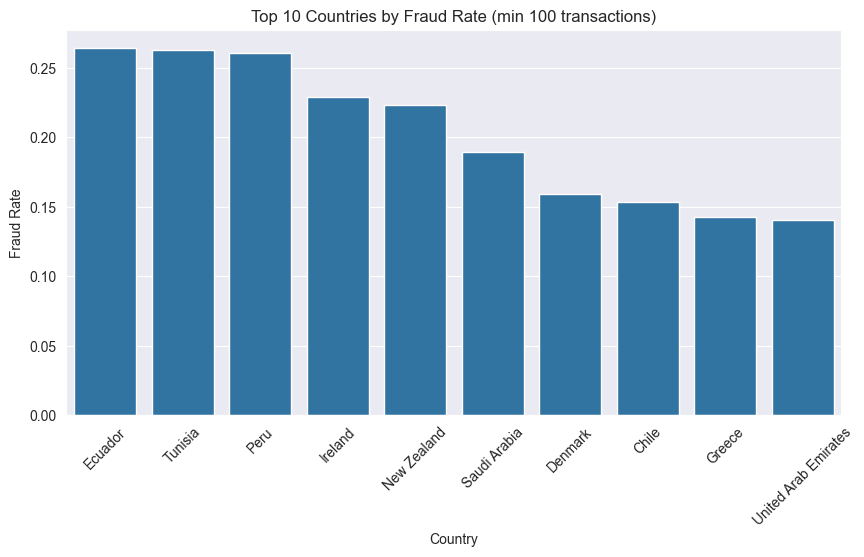

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(
    data=country_stats_sorted.head(10),
    x=country_stats_sorted.head(10).index,
    y="fraud_rate"
)
plt.title("Top 10 Countries by Fraud Rate (min 100 transactions)")
plt.ylabel("Fraud Rate")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.show()


In [5]:
class_counts = df["class"].value_counts().sort_index()
fraud_rate = class_counts[1] / len(df)

print("\nClass distribution:")
print(class_counts)

print(f"\nFraud rate: {fraud_rate:.6f}")
fraud_by_user = (
    df.groupby("user_id")["class"]
    .mean()
    .sort_values(ascending=False)
)

print("\nTop 10 users by fraud rate:")
display(fraud_by_user.head(10))

fraud_txn_share = df[df["class"] == 1].shape[0] / df.shape[0]
print(f"Share of transactions that are fraud: {fraud_txn_share:.6f}")





Class distribution:
class
0    136961
1     14151
Name: count, dtype: int64

Fraud rate: 0.093646

Top 10 users by fraud rate:


user_id
199959    1.0
158562    1.0
158955    1.0
158943    1.0
158931    1.0
158884    1.0
158852    1.0
158782    1.0
158779    1.0
158696    1.0
Name: class, dtype: float64

Share of transactions that are fraud: 0.093646



--- First 5 Rows ---


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,time_since_signup_seconds
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,4506682.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,17944.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,1.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,492085.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,4361461.0



--- Class Distribution ---
class
0    136961
1     14151
Name: count, dtype: int64

Fraud Rate: 9.3646%


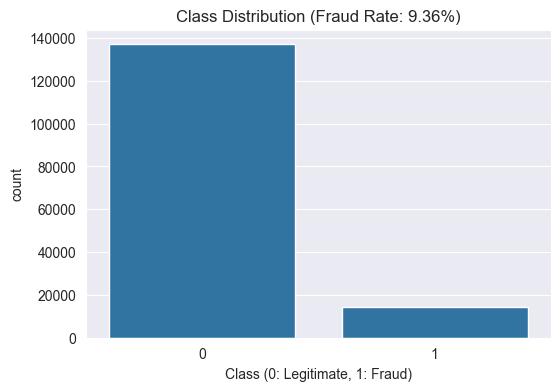

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2. First Look
print("\n--- First 5 Rows ---")
display(df.head())

# 4. The Critical Check: Class Imbalance
fraud_counts = df['class'].value_counts()
fraud_rate = (fraud_counts[1] / len(df)) * 100
print("\n--- Class Distribution ---")
print(fraud_counts)
print(f"\nFraud Rate: {fraud_rate:.4f}%")

# 5. Quick Visualization of the Imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df)
plt.title(f'Class Distribution (Fraud Rate: {fraud_rate:.2f}%)')
plt.xlabel('Class (0: Legitimate, 1: Fraud)')
plt.show()

In [7]:
# Transactions per user
user_txn_counts = df.groupby("user_id").size()

# Fraud transactions per user
user_fraud_counts = df[df["class"] == 1].groupby("user_id").size()

user_summary = pd.DataFrame({
    "total_txns": user_txn_counts,
    "fraud_txns": user_fraud_counts
}).fillna(0)

user_summary["fraud_rate"] = user_summary["fraud_txns"] / user_summary["total_txns"]

print("User summary shape:", user_summary.shape)
display(user_summary.sort_values("fraud_txns", ascending=False).head(10))

fraud_sorted = user_summary.sort_values("fraud_txns", ascending=False)
fraud_sorted["cum_fraud"] = fraud_sorted["fraud_txns"].cumsum()
fraud_sorted["cum_fraud_pct"] = fraud_sorted["cum_fraud"] / fraud_sorted["fraud_txns"].sum()

display(fraud_sorted.head(10))


User summary shape: (151112, 3)


,total_txns,fraud_txns,fraud_rate
user_id,,,
199959,1,1.0,1.0
158562,1,1.0,1.0
158955,1,1.0,1.0
158943,1,1.0,1.0
158931,1,1.0,1.0
158884,1,1.0,1.0
158852,1,1.0,1.0
158782,1,1.0,1.0
158779,1,1.0,1.0


,total_txns,fraud_txns,fraud_rate,cum_fraud,cum_fraud_pct
user_id,,,,,
199959,1,1.0,1.0,1.0,0.000071
158562,1,1.0,1.0,2.0,0.000141
158955,1,1.0,1.0,3.0,0.000212
158943,1,1.0,1.0,4.0,0.000283
158931,1,1.0,1.0,5.0,0.000353
158884,1,1.0,1.0,6.0,0.000424
158852,1,1.0,1.0,7.0,0.000495
158782,1,1.0,1.0,8.0,0.000565
158779,1,1.0,1.0,9.0,0.000636


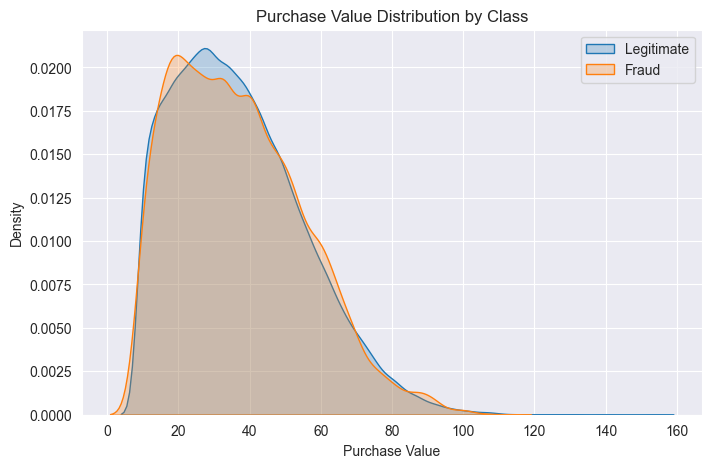

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.kdeplot(df[df["class"] == 0]["purchase_value"], label="Legitimate", fill=True)
sns.kdeplot(df[df["class"] == 1]["purchase_value"], label="Fraud", fill=True)
plt.title("Purchase Value Distribution by Class")
plt.xlabel("Purchase Value")
plt.legend()
plt.show()


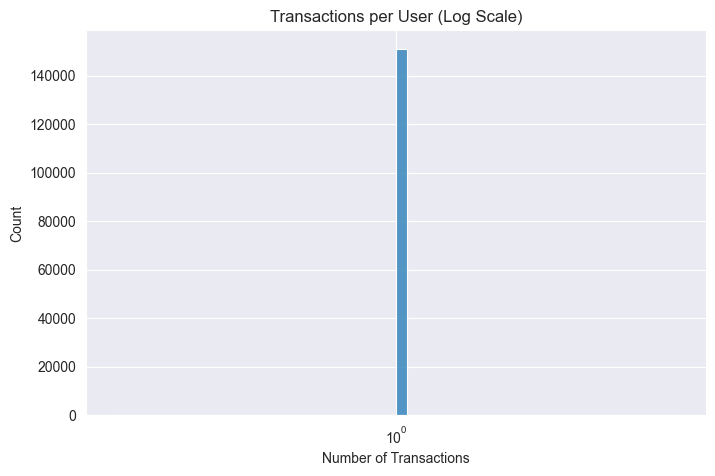

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(user_summary["total_txns"], bins=50, log_scale=True)
plt.title("Transactions per User (Log Scale)")
plt.xlabel("Number of Transactions")
plt.show()


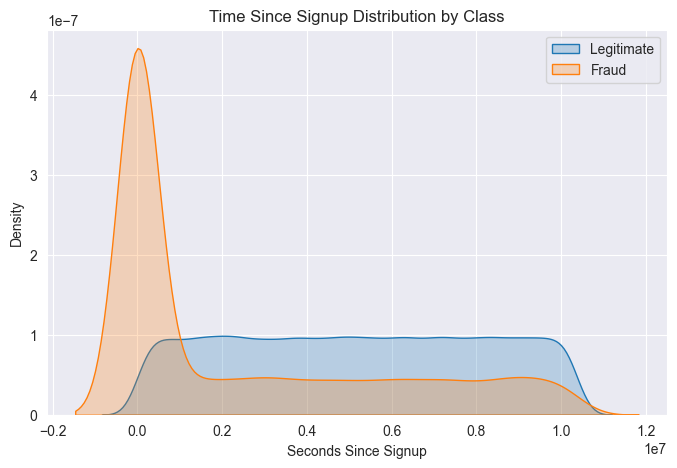

In [10]:
plt.figure(figsize=(8, 5))
sns.kdeplot(
    df[df["class"] == 0]["time_since_signup_seconds"],
    label="Legitimate",
    fill=True
)
sns.kdeplot(
    df[df["class"] == 1]["time_since_signup_seconds"],
    label="Fraud",
    fill=True
)
plt.title("Time Since Signup Distribution by Class")
plt.xlabel("Seconds Since Signup")
plt.legend()
plt.show()


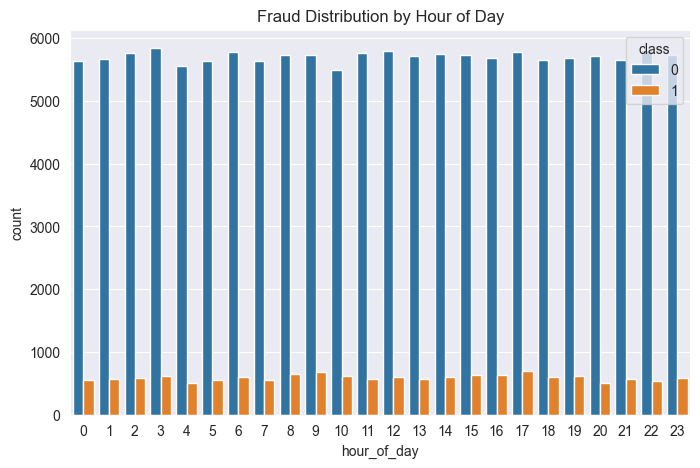

In [11]:
# Ensure timestamps are datetime
df["signup_time"] = pd.to_datetime(df["signup_time"])
df["purchase_time"] = pd.to_datetime(df["purchase_time"])

# Time-based features
df["hour_of_day"] = df["purchase_time"].dt.hour
df["day_of_week"] = df["purchase_time"].dt.dayofweek  # 0=Monday

df[["hour_of_day", "day_of_week"]].describe()

#visualize fraud patterns
plt.figure(figsize=(8, 5))
sns.countplot(x="hour_of_day", hue="class", data=df)
plt.title("Fraud Distribution by Hour of Day")
plt.show()


In [12]:
user_txn_stats = (
    df.groupby("user_id")
    .agg(
        user_total_txns=("class", "count"),
        user_fraud_txns=("class", "sum")
    )
    .reset_index()
)

user_txn_stats["user_fraud_rate"] = (
    user_txn_stats["user_fraud_txns"] / user_txn_stats["user_total_txns"]
)

df = df.merge(user_txn_stats, on="user_id", how="left")

df[["user_total_txns", "user_fraud_rate"]].describe()


,user_total_txns,user_fraud_rate
count,151112.0,151112.000000
mean,1.0,0.093646
std,0.0,0.291336
min,1.0,0.000000
25%,1.0,0.000000
50%,1.0,0.000000
75%,1.0,0.000000
max,1.0,1.000000


In [13]:
#Fraudsters reuse devices
device_stats = (
    df.groupby("device_id")
    .agg(
        device_txn_count=("class", "count"),
        device_fraud_rate=("class", "mean")
    )
    .reset_index()
)

df = df.merge(device_stats, on="device_id", how="left")
#inspect extreme cases
df.sort_values("device_fraud_rate", ascending=False).head(10)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,time_since_signup_seconds,hour_of_day,day_of_week,user_total_txns,user_fraud_txns,user_fraud_rate,device_txn_count,device_fraud_rate
29638,70360,2015-01-08 14:11:59,2015-01-11 17:21:53,19,YFPWTBTQRBNYZ,SEO,Chrome,F,33,3.612352e+09,1,270594.0,17,6,1,1,1.0,2,1.0
57056,236043,2015-01-17 22:37:22,2015-04-26 22:54:40,11,XNBHWMNYGRGIM,Ads,FireFox,F,42,1.949662e+08,1,8554638.0,22,6,1,1,1.0,1,1.0
42513,280624,2015-02-21 04:10:04,2015-02-21 09:05:55,51,DKYBZPVMCXGMP,SEO,Chrome,M,45,1.222620e+09,1,17751.0,9,5,1,1,1.0,1,1.0
40649,30146,2015-07-23 21:50:27,2015-11-17 22:37:45,13,ABXVQZTJLNBOL,SEO,FireFox,M,53,3.167752e+09,1,10111638.0,22,1,1,1,1.0,1,1.0
147967,396448,2015-01-04 06:43:08,2015-01-04 06:43:09,60,VSZLPCXAISHQC,SEO,Chrome,F,35,2.614813e+08,1,1.0,6,6,1,1,1.0,16,1.0
21823,340076,2015-08-17 07:38:14,2015-09-19 06:50:17,35,RLZVAQEGCENBS,SEO,Chrome,F,26,2.990406e+09,1,2848323.0,6,5,1,1,1.0,1,1.0
119627,245167,2015-02-28 03:37:37,2015-05-25 20:15:32,83,PPSTSDSFOOLCY,Ads,Safari,F,21,3.914756e+09,1,7490275.0,20,0,1,1,1.0,2,1.0
117370,360039,2015-03-17 04:31:32,2015-06-16 15:27:41,27,AWRDCHFREFDTF,Ads,IE,M,38,1.647816e+09,1,7901769.0,15,1,1,1,1.0,1,1.0
10889,157431,2015-03-15 07:19:01,2015-05-02 21:56:16,31,JVSROINIAYAYZ,Ads,IE,F,26,1.599672e+09,1,4199835.0,21,5,1,1,1.0,1,1.0
47937,182917,2015-06-22 00:37:50,2015-09-29 21:52:59,21,MOSUYRRSLBLAR,SEO,Chrome,F,36,3.778458e+09,1,8630109.0,21,1,1,1,1.0,1,1.0


In [14]:
# IP reuse statistics
ip_stats = (
    df.groupby("ip_address")
    .agg(
        ip_txn_count=("class", "count"),
        ip_fraud_rate=("class", "mean")
    )
    .reset_index()
)

df = df.merge(ip_stats, on="ip_address", how="left")

df[["ip_txn_count", "ip_fraud_rate"]].describe()


,ip_txn_count,ip_fraud_rate
count,151112.000000,151112.000000
mean,1.602719,0.093646
std,2.596240,0.283818
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,0.000000
max,20.000000,1.000000


In [15]:

#look at the riskiest IPs
df.sort_values("ip_fraud_rate", ascending=False).head(10)



,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,time_since_signup_seconds,hour_of_day,day_of_week,user_total_txns,user_fraud_txns,user_fraud_rate,device_txn_count,device_fraud_rate,ip_txn_count,ip_fraud_rate
50919,9267,2015-02-22 13:24:12,2015-06-04 05:37:59,27,FRKCKLUUCDRFL,Ads,Safari,M,27,2.618542e+09,...,8784827.0,5,3,1,1,1.0,2,0.5,1,1.0
50502,200536,2015-05-21 20:06:55,2015-06-30 22:29:29,17,BWONOERWJEBSW,Direct,FireFox,M,30,3.769668e+09,...,3464554.0,22,1,1,1,1.0,1,1.0,1,1.0
69409,338395,2015-01-14 11:16:12,2015-03-17 01:18:31,19,XJFHTHLOSHSPR,Ads,IE,M,31,1.825995e+09,...,5320939.0,1,1,1,1,1.0,1,1.0,1,1.0
139990,397906,2015-08-16 12:23:51,2015-10-31 22:35:23,18,HAURQDAGUGXJC,Ads,Chrome,M,49,2.067141e+09,...,6603092.0,22,5,1,1,1.0,1,1.0,1,1.0
139985,49679,2015-02-13 08:03:14,2015-05-27 07:44:33,20,UQUIBOUDMHMVY,Ads,IE,F,32,2.290979e+08,...,8898079.0,7,2,1,1,1.0,2,0.5,1,1.0
88508,13459,2015-03-22 18:04:56,2015-06-25 23:12:14,50,LZQVCNVOTRZGG,SEO,Safari,F,49,6.801200e+08,...,8226438.0,23,3,1,1,1.0,2,0.5,1,1.0
69395,126865,2015-07-12 13:41:50,2015-10-16 04:17:24,60,CXHHQRUCSNIPU,Ads,Safari,M,26,3.753701e+09,...,8260534.0,4,4,1,1,1.0,1,1.0,1,1.0
50497,197331,2015-08-14 18:51:51,2015-11-04 11:44:39,26,CZKWCHJTOMXAY,SEO,Chrome,F,34,4.130963e+09,...,7059168.0,11,2,1,1,1.0,2,0.5,1,1.0
12425,380100,2015-08-05 04:53:02,2015-12-01 15:26:56,69,SXCRKHPQCAAFH,Ads,Chrome,M,29,1.534913e+08,...,10233234.0,15,1,1,1,1.0,1,1.0,1,1.0
88521,24219,2015-03-23 05:11:22,2015-05-23 16:52:33,16,NOXZPXKQOHLSL,SEO,FireFox,M,35,2.418628e+09,...,5312471.0,16,5,1,1,1.0,2,0.5,1,1.0


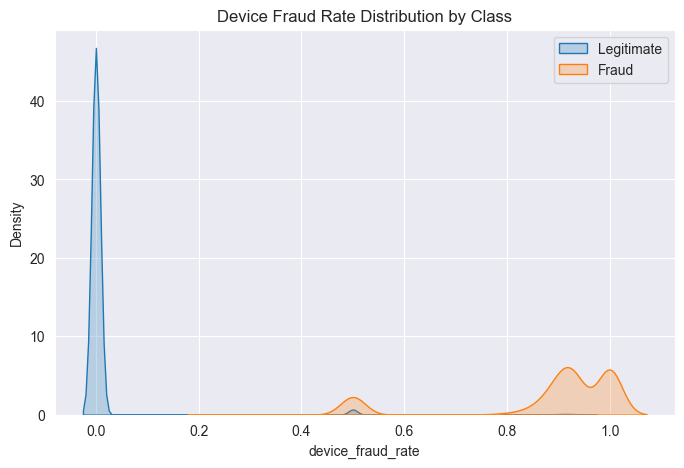

In [16]:
plt.figure(figsize=(8, 5))
sns.kdeplot(
    df[df["class"] == 0]["device_fraud_rate"],
    label="Legitimate",
    fill=True
)
sns.kdeplot(
    df[df["class"] == 1]["device_fraud_rate"],
    label="Fraud",
    fill=True
)
plt.title("Device Fraud Rate Distribution by Class")
plt.legend()
plt.show()


In [17]:
df["ip_address_int"] = df["ip_address"].astype("int64")

df["ip_address_int"].describe()


count    1.511120e+05
mean     2.152145e+09
std      1.248497e+09
min      5.209300e+04
25%      1.085934e+09
50%      2.154770e+09
75%      3.243258e+09
max      4.294850e+09
Name: ip_address_int, dtype: float64

In [18]:
df["ip_address_int"] = df["ip_address"].astype("int64")



In [19]:
df["ip_address_int"].apply(lambda x: isinstance(x, int)).all()


True

In [20]:
df["ip_address_int"].describe()


count    1.511120e+05
mean     2.152145e+09
std      1.248497e+09
min      5.209300e+04
25%      1.085934e+09
50%      2.154770e+09
75%      3.243258e+09
max      4.294850e+09
Name: ip_address_int, dtype: float64

In [21]:
print("DF type:", type(df))
print("DF shape:", df.shape)
print("Any NaNs:", df.isna().any().any())
print("Head:")
display(df.head())
print("Tail:")
display(df.tail())


DF type: <class 'pandas.core.frame.DataFrame'>
DF shape: (151112, 22)
Any NaNs: False
Head:


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,hour_of_day,day_of_week,user_total_txns,user_fraud_txns,user_fraud_rate,device_txn_count,device_fraud_rate,ip_txn_count,ip_fraud_rate,ip_address_int
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,2,5,1,0,0.0,1,0.000000,1,0.000000,732758368
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,1,0,1,0,0.0,1,0.000000,1,0.000000,350311387
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,18,3,1,1,1.0,12,0.916667,12,0.916667,2621473820
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,13,0,1,0,0.0,1,0.000000,1,0.000000,3840542443
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,18,2,1,0,0.0,1,0.000000,1,0.000000,415583117


Tail:


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,hour_of_day,day_of_week,user_total_txns,user_fraud_txns,user_fraud_rate,device_txn_count,device_fraud_rate,ip_txn_count,ip_fraud_rate,ip_address_int
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,...,0,6,1,1,1.0,2,0.5,1,1.0,3451154526
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,...,12,1,1,0,0.0,1,0.0,1,0.0,2439047221
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,...,7,2,1,0,0.0,1,0.0,1,0.0,2748470523
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,...,9,0,1,0,0.0,2,0.0,1,0.0,3601174708
151111,138208,2015-06-10 07:02:20,2015-07-21 02:03:53,20,ZINIADFCLHYPG,Direct,IE,M,38,4.103825e+09,...,2,1,1,0,0.0,1,0.0,1,0.0,4103824510


In [23]:
output_path = "../data/interim/fraud_interim_features.csv"
df.to_csv(
    output_path,
    index=False,
    encoding="utf-8"
)

print("Saved rows:", sum(1 for _ in open(output_path)) - 1)


Saved rows: 151112


In [ ]:
# ============================================================
# GEOLOCATION INTEGRATION: IP -> COUNTRY (TASK 1 REQUIREMENT)
# ============================================================

import pandas as pd

# -------------------------------
# 1. Load IP-to-Country Mapping
# -------------------------------
ip_country_path = "../data/raw/IpAddress_to_Country.csv"
ip_df = pd.read_csv(ip_country_path)

# -------------------------------
# 2. Convert IPs to Integer Format
# -------------------------------
# Create a clean integer IP column without touching raw data
df["ip_address_int"] = df["ip_address"].astype(int)

ip_df["lower_bound_ip_address"] = ip_df["lower_bound_ip_address"].astype(int)
ip_df["upper_bound_ip_address"] = ip_df["upper_bound_ip_address"].astype(int)

# -------------------------------
# 3. Sort for Range-Based Merge
# -------------------------------
df = df.sort_values("ip_address_int")
ip_df = ip_df.sort_values("lower_bound_ip_address")

# -------------------------------
# 4. Range-Based Lookup (merge_asof)
# -------------------------------
df = pd.merge_asof(
    df,
    ip_df,
    left_on="ip_address_int",
    right_on="lower_bound_ip_address",
    direction="backward"
)

# Validate that IP is within the upper bound
invalid_mask = df["ip_address_int"] > df["upper_bound_ip_address"]
df.loc[invalid_mask, "country"] = "Unknown"

# Clean up helper columns
df.drop(
    columns=["lower_bound_ip_address", "upper_bound_ip_address"],
    inplace=True
)

df["country"] = df["country"].fillna("Unknown")

# -------------------------------
# 5. Sanity Check
# -------------------------------
print("Top 10 countries by transaction count:")
display(df["country"].value_counts().head(10))

print("\nPercentage of Unknown countries:")
print((df["country"] == "Unknown").mean() * 100)
